# Introduction to machine learning demo

Load required packages

In [1]:
# some weird stuff
setwd('../..')
old_paths = .libPaths()
my_paths = c("packrat/lib/x86_64-apple-darwin15.6.0/3.6.2",    
"packrat/lib-ext/x86_64-apple-darwin15.6.0/3.6.2",
"packrat/lib-R/x86_64-apple-darwin15.6.0/3.6.2"  )
.libPaths(c(old_paths, my_paths))

# plot size
options(repr.plot.res = 200)


In [2]:
decisionplot <- function(model, data, class = NULL, predict_type = "raw",
  resolution = 100, showgrid = TRUE, ...) {

  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  plot(data, col = as.integer(cl)+1L, pch = as.integer(cl)+1L, ...)

  # make grid
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)

  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  if(is.list(p)) p <- p$class
  p <- as.factor(p)

  if(showgrid) points(g, col = as.integer(p)+1L, pch = ".")

  z <- matrix(as.integer(p), nrow = resolution, byrow = TRUE)
  contour(xs, ys, z, add = TRUE, drawlabels = FALSE,
    lwd = 2, levels = (1:(k-1))+.5)

  invisible(z)
}

In [3]:
suppressPackageStartupMessages(library(xgboost))
suppressPackageStartupMessages(library(recipes)) 
suppressPackageStartupMessages(library(skimr))
suppressPackageStartupMessages(library(tidyverse))
# suppressPackageStartupMessages(library(plotly))
# suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(rattle))
suppressPackageStartupMessages(library(ggrepel))

## Outline
### 1. Classification: Predicting flower species
### 2. Regression: Predicting house prices

### Classification

In [5]:
data(iris)

In [ ]:
summary(iris)

In [ ]:
ggpairs( iris,
        columns = 1:4, aes(color=Species, alpha=0.5),
        axisLabels = 'none', switch = 'both') +
        theme_bw()

In [ ]:
ggplot(data = iris, mapping = aes(x = Species, y= Petal.Length, fill=Species)) +
    geom_boxplot()

In [ ]:
head(iris)
pivot_longer(iris, cols=-Species, names_to='feature', values_to='value') %>%
ggplot(mapping = aes(x=Species, y=value, fill=Species)) +
geom_boxplot() +
facet_wrap(~feature)

### machine learning

In [14]:
set.seed(2020)

train_size = 0.75

train_index <- createDataPartition(y = iris$Species,
                                    p = train_size,
                                   list = F,
                                   time = 1)

train_data <- iris[train_index,]
test_data <- iris[-train_index,]

In [47]:
# decision trees
fitControl <- trainControl(
                method ='cv', 
                number = 10, 
                classProbs = T,
#                 summaryFunction = multiClassSummary,
                savePredictions = T)

parameters: learnt from training data
hyperparameters: influence how it learns the parameters

In [49]:
dt_model <- train(Species ~ .,
                 data = train_data,
                 method = 'rpart',
#                  metric = 'AUC',
                 tuneGrid = expand.grid(cp = seq(0,0.6,by=0.1)),
                 trControl = fitControl)

In [50]:
dt_train_results <- confusionMatrix(dt_model)
dt_train_results

Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
            Reference
Prediction   setosa versicolor virginica
  setosa       33.3        0.0       0.0
  versicolor    0.0       31.6       2.6
  virginica     0.0        1.8      30.7
                            
 Accuracy (average) : 0.9561


In [30]:
dt_preds <- predict(dt_model, test_data)

In [51]:
dt_model

CART 

114 samples
  4 predictor
  3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 102, 102, 102, 103, 102, 103, ... 
Resampling results across tuning parameters:

  cp   Accuracy   Kappa    
  0.0  0.9560606  0.9339198
  0.1  0.9560606  0.9339198
  0.2  0.9560606  0.9339198
  0.3  0.9560606  0.9339198
  0.4  0.9560606  0.9339198
  0.5  0.3057576  0.0000000
  0.6  0.3057576  0.0000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.4.

In [19]:
dt_test_results <- confusionMatrix(dt_preds, test_data$Species)
dt_test_results

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0          9         2
  virginica       0          3        10

Overall Statistics
                                         
               Accuracy : 0.8611         
                 95% CI : (0.705, 0.9533)
    No Information Rate : 0.3333         
    P-Value [Acc > NIR] : 8.705e-11      
                                         
                  Kappa : 0.7917         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.7500           0.8333
Specificity                 1.0000            0.9167           0.8750
Pos Pred Value              1.0000            0.8182           0.7692
Neg Pred Value              1.0000            0.8800           0.9130
Prevalence

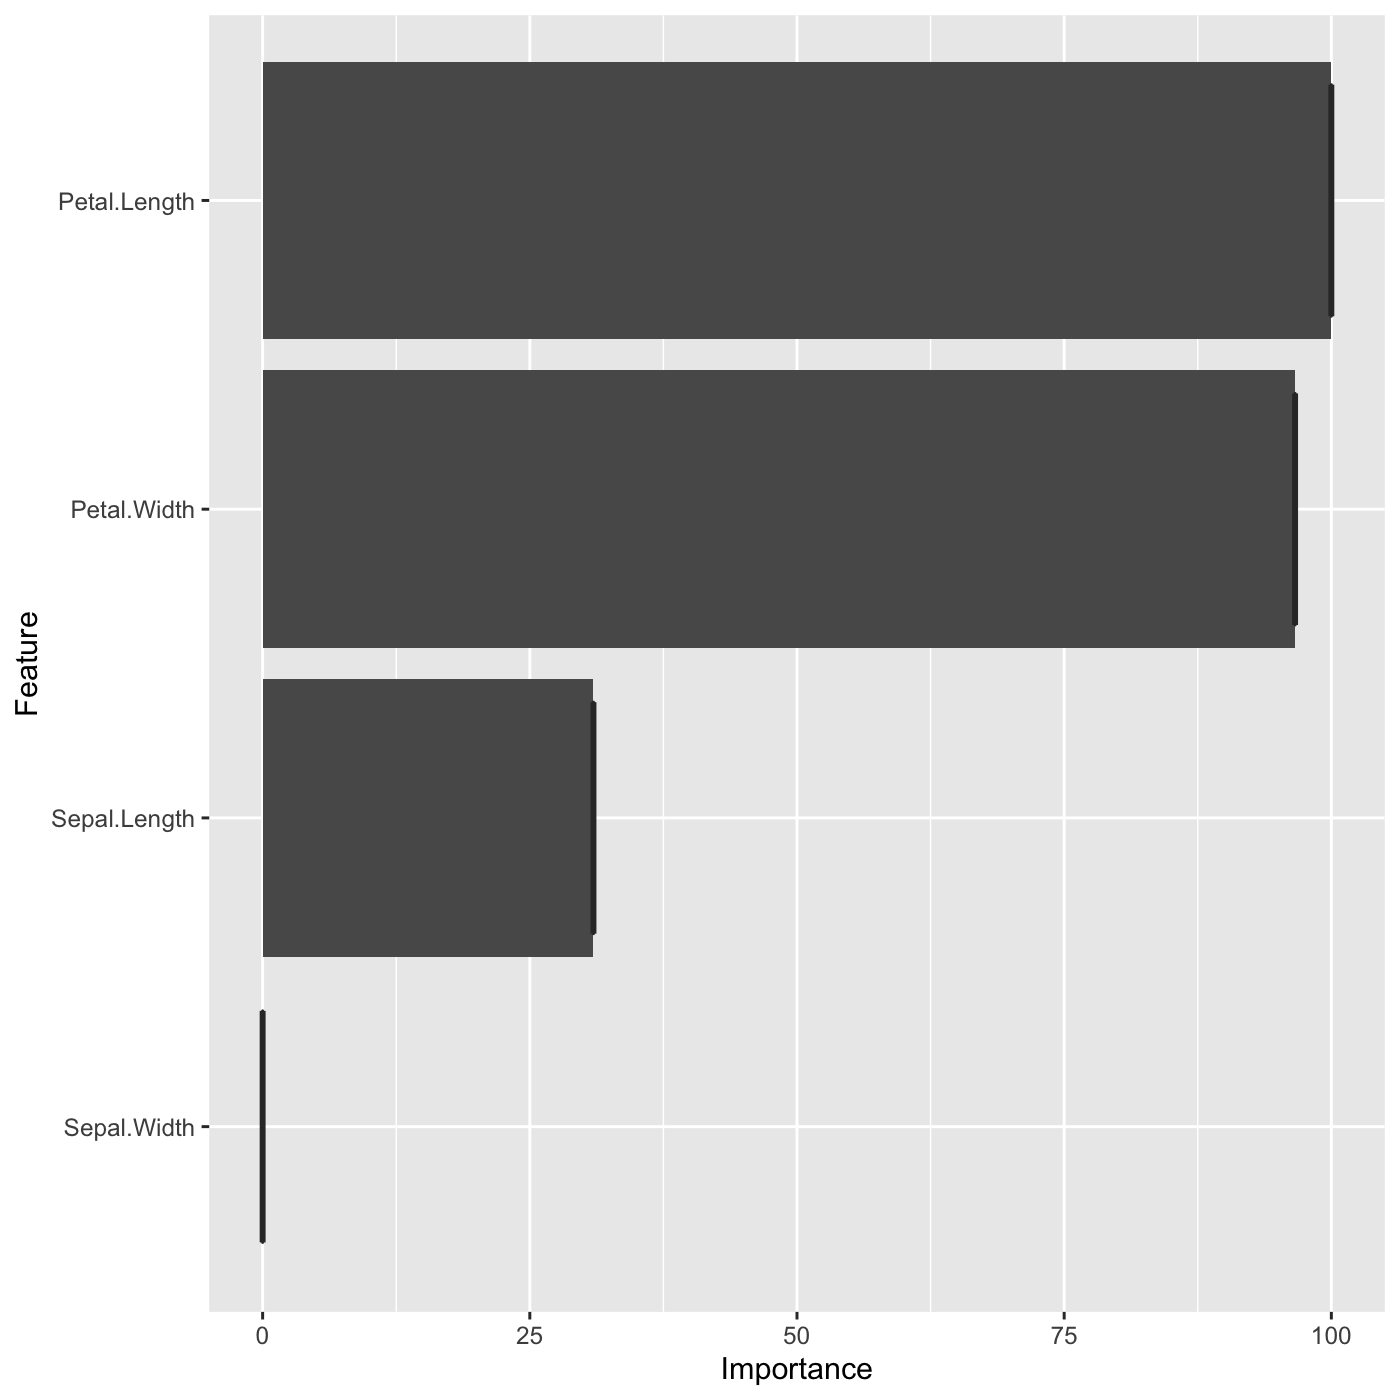

In [20]:
dt_feat_importance <- varImp(dt_model)

ggplot(data = dt_feat_importance) +
    geom_boxplot()

In [ ]:
fancyRpartPlot(dt_model$finalModel, sub = 'my decision tree')

In [58]:
expand.grid(C = seq(0.25,1,by=0.1), sigma = c(0.6))

C,sigma
<dbl>,<dbl>
0.25,0.6
0.35,0.6
0.45,0.6
0.55,0.6
0.65,0.6
0.75,0.6
0.85,0.6
0.95,0.6


In [56]:
svm_model <- train(Species ~ .,
                 data = train_data,
                 method = 'svmRadial',
#                  metric = 'AUC',
#                  tuneGrid = expand.grid(C = seq(0.25,1,by=0.1), sigma = c(0.6)),
                 trControl = fitControl)

In [57]:
svm_model

Support Vector Machines with Radial Basis Function Kernel 

114 samples
  4 predictor
  3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 103, 102, 102, 102, 103, 102, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.9636364  0.9449957
  0.35  0.9734848  0.9600000
  0.45  0.9734848  0.9600000
  0.55  0.9734848  0.9601698
  0.65  0.9643939  0.9464198
  0.75  0.9734848  0.9600000
  0.85  0.9734848  0.9601698
  0.95  0.9734848  0.9601698

Tuning parameter 'sigma' was held constant at a value of 0.6
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.6 and C = 0.35.

In [80]:
fitControl <- trainControl(
                method ='cv', 
                number = 10, 
                classProbs = T,
#                 summaryFunction = multiClassSummary,
                selectionFunction = 'tolerance',
                savePredictions = T)

In [81]:
set.seed(2020)
knn_model <- train(Species ~ .,
                 data = train_data,
                 method = 'knn',
#                  metric = 'AUC',
                 tuneGrid = expand.grid(k = seq(1,9,by=1)),
                 trControl = fitControl)

In [82]:
knn_model

k-Nearest Neighbors 

114 samples
  4 predictor
  3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 104, 102, 102, 102, 102, 103, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa 
  1  0.9750000  0.9625
  2  0.9833333  0.9750
  3  0.9833333  0.9750
  4  0.9833333  0.9750
  5  0.9833333  0.9750
  6  0.9750000  0.9625
  7  0.9750000  0.9625
  8  0.9750000  0.9625
  9  0.9833333  0.9750

Accuracy was used to select the optimal model using  a tolerance rule.
The final value used for the model was k = 9.

In [84]:
model_list <- resamples(list(decision_trees = dt_model,
                              support_vector_machines = svm_model,
                              k_nearest_neighbors = knn_model)
                        )


In [85]:
summary(model_list)


Call:
summary.resamples(object = model_list)

Models: decision_trees, support_vector_machines, k_nearest_neighbors 
Number of resamples: 10 

Accuracy 
                             Min.   1st Qu. Median      Mean 3rd Qu. Max. NA's
decision_trees          0.8333333 0.9090909      1 0.9560606       1    1    0
support_vector_machines 0.9090909 0.9375000      1 0.9734848       1    1    0
k_nearest_neighbors     0.9166667 1.0000000      1 0.9833333       1    1    0

Kappa 
                          Min.   1st Qu. Median      Mean 3rd Qu. Max. NA's
decision_trees          0.7500 0.8629244      1 0.9339198       1    1    0
support_vector_machines 0.8625 0.9062500      1 0.9600000       1    1    0
k_nearest_neighbors     0.8750 1.0000000      1 0.9750000       1    1    0


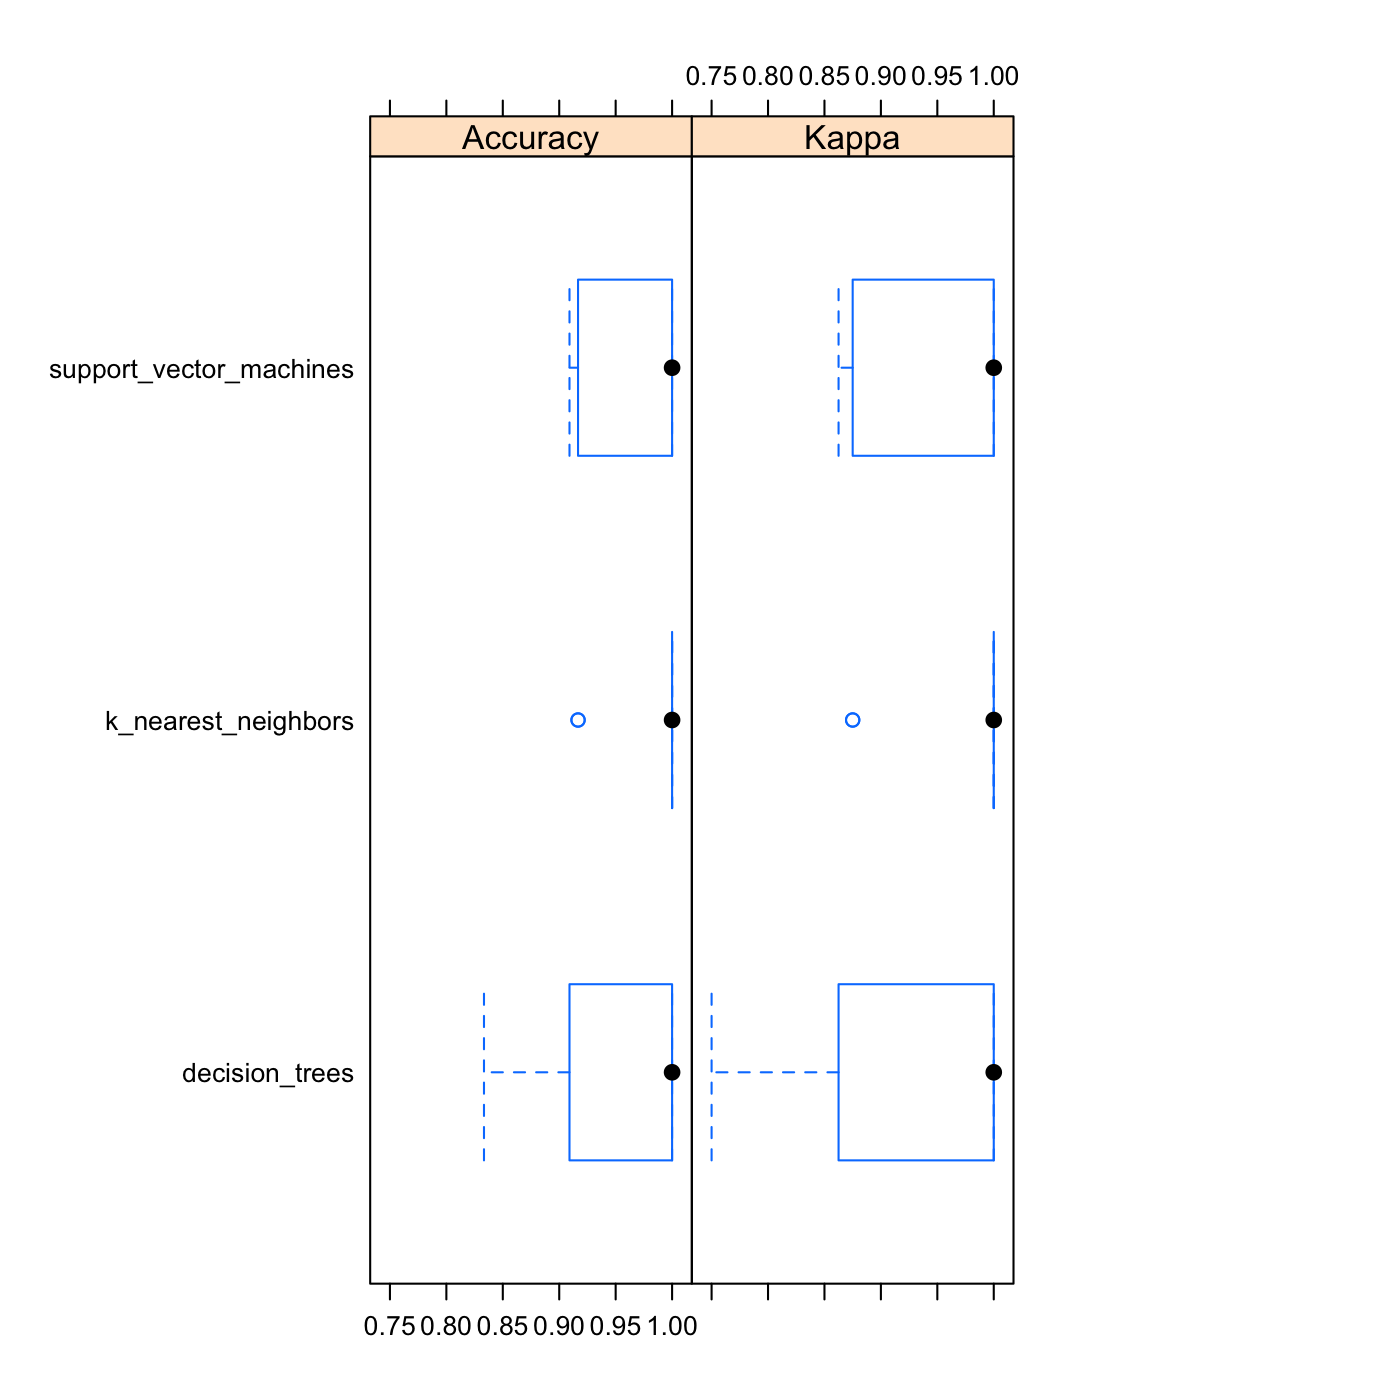

In [86]:
bwplot(model_list, layout = c(3,1))

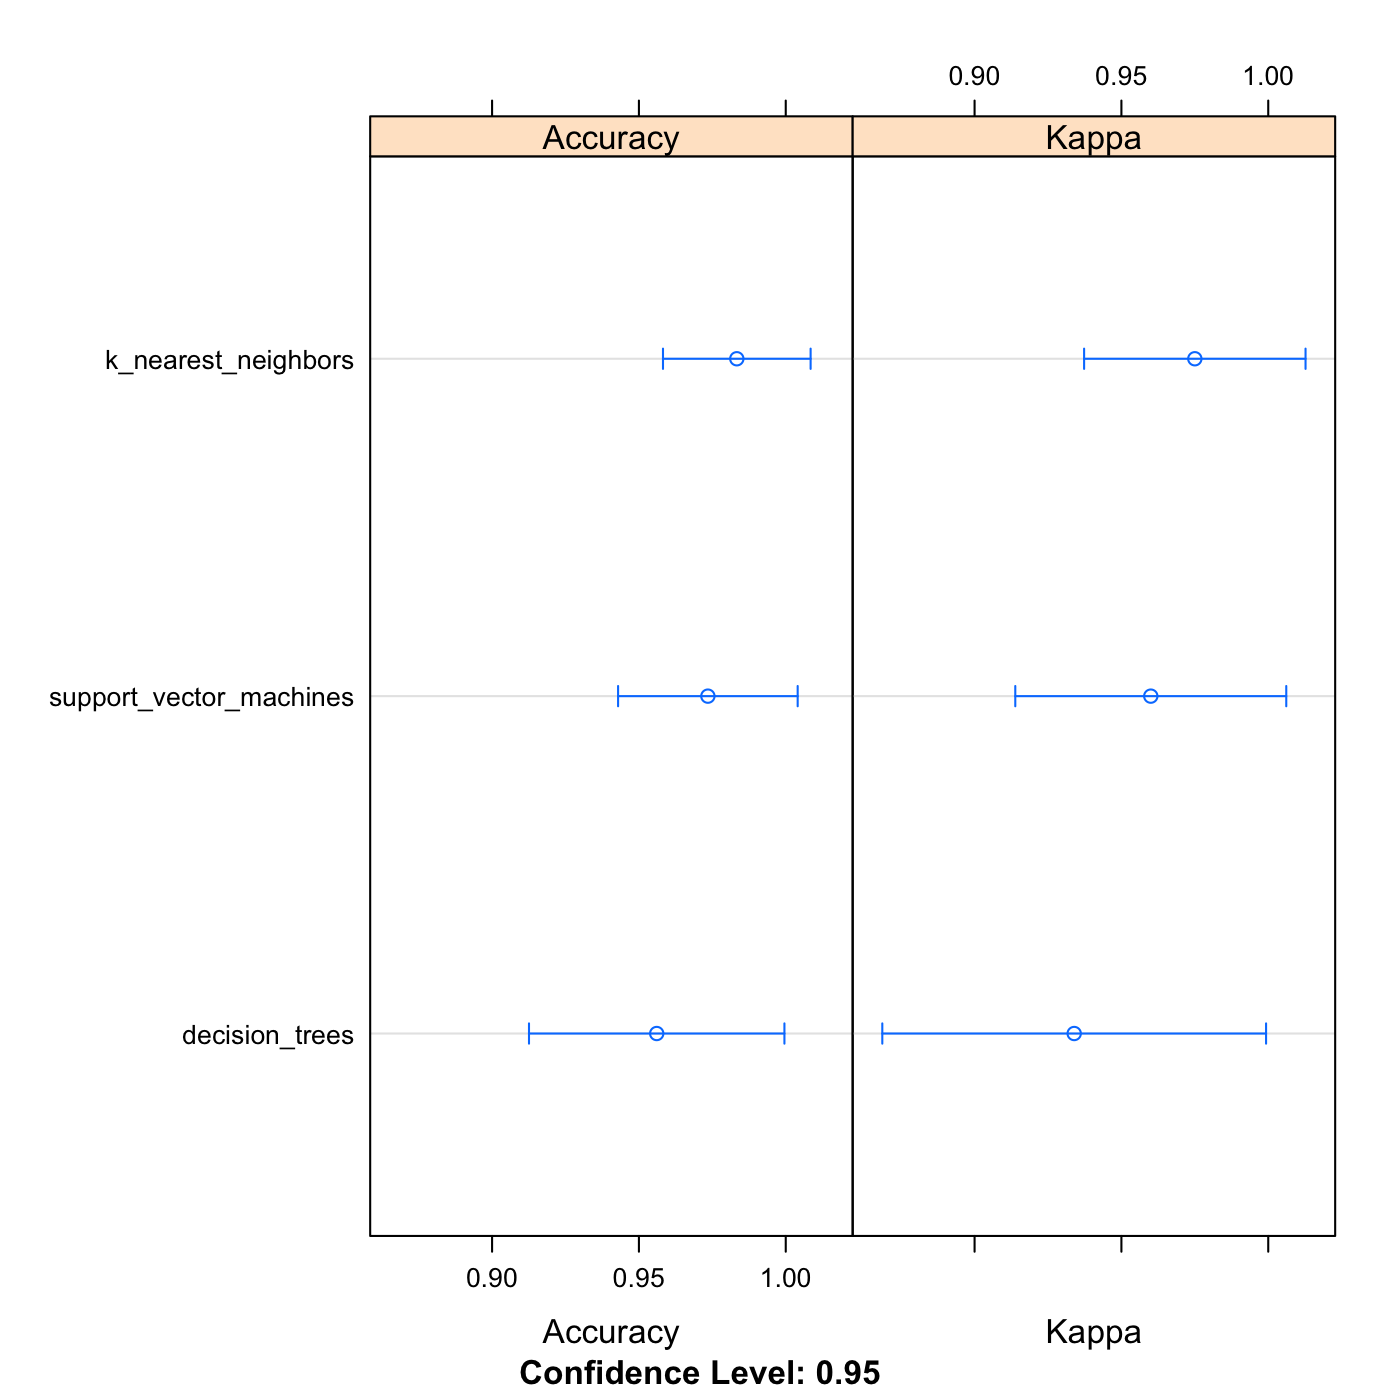

In [87]:
dotplot(model_list)

In [88]:
model_diff <- diff(model_list)
summary(model_diff)


Call:
summary.diff.resamples(object = model_diff)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

Accuracy 
                        decision_trees support_vector_machines
decision_trees                         -0.017424              
support_vector_machines 1.0000                                
k_nearest_neighbors     0.5319         1.0000                 
                        k_nearest_neighbors
decision_trees          -0.027273          
support_vector_machines -0.009848          
k_nearest_neighbors                        

Kappa 
                        decision_trees support_vector_machines
decision_trees                         -0.02608               
support_vector_machines 1.0000                                
k_nearest_neighbors     0.5297         1.0000                 
                        k_nearest_neighbors
decision_trees          -0.04108           
support_vector_machines -0.01500      

In [90]:
seed_test<-(file = "https://github.com/toyetund-nmdp/teaching_APSC8280/tree/master/datasets/seeds/seed_test.csv")

,X..DOCTYPE.html.
,<fct>
1,<html lang=en>
2,<head>
3,<meta charset=utf-8>
4,<link rel=dns-prefetch href=https://github.githubassets.com>
5,<link rel=dns-prefetch href=https://avatars0.githubusercontent.com>
6,<link rel=dns-prefetch href=https://avatars1.githubusercontent.com>
